In [1]:
#Credits Navya Chennagiri Ravikumar
#SID: 014352130
#Kaggle username: navyacr
#RMSE (at the time of writing this report) = 15.67862
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection.split import train_test_split
from surprise.model_selection import cross_validate, GridSearchCV
import pandas as pd
import numpy as np
import os, io
from surprise import KNNBasic, KNNWithMeans
from surprise import SVDpp
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import KFold, ShuffleSplit, RepeatedKFold, PredefinedKFold
import matplotlib.pyplot as plt
import surprise
dir(surprise.model_selection)


['GridSearchCV',
 'KFold',
 'LeaveOneOut',
 'PredefinedKFold',
 'RandomizedSearchCV',
 'RepeatedKFold',
 'ShuffleSplit',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'cross_validate',
 'search',
 'split',
 'train_test_split',
 'validation']

In [2]:
print (os.getcwd())
#print(os.listdir("../input/cmpe256-S20-song-recommendation-system/train.csv"))

/kaggle/working


Reading data from .csv file into the dataframe using pandas read_csv()

In [3]:
dataframe = pd.read_csv('../input/cmpe256-S20-song-recommendation-system/train.csv')
dataframe.head()

,User,Track,Rating
0,1,0,27
1,4,0,10
2,8,0,30
3,10,0,30
4,11,0,14


**Using Surprise library's Reader class**

Reader class of the Surprise documentation is used, scale is set from 0 to 100 as expected in the sample output.

In [4]:
#create train set
reader = Reader(rating_scale = (0,100))
data = Dataset.load_from_df(dataframe, reader)
type(data)

surprise.dataset.DatasetAutoFolds

Training data consists of three columns: **User, Track and Rating**. Dataframe below shows the first five rows of the training data.

In [5]:
dataframe.head()

,User,Track,Rating
0,1,0,27
1,4,0,10
2,8,0,30
3,10,0,30
4,11,0,14


**Data visulization**

The train set has 47856 users, 184 tracks and 101 ratings(i.e., 0 to 100).
The shape of this dataset is (150999, 3), which implies that most of the users have rated multiple tracks.
Therefore the train data can be analysed in three ways:

1. Ratings pattern

2. User based rating distribution

3. Item (Track) based rating distribution


In [6]:
print('No. of Unique Users    :', dataframe.User.nunique())
print('No. of Unique tracks :', dataframe.Track.nunique())
print('No. of Unique Ratings  :', dataframe.Rating.nunique())
print('Dataset shape: {}'.format(dataframe.shape))

No. of Unique Users    : 47856
No. of Unique tracks : 184
No. of Unique Ratings  : 101
Dataset shape: (150999, 3)


**1. Ratings Pattern**

Analysis of the ratings based on its frequency. A plot of ratings vs frequency is implemented below.


In [7]:
freq = dataframe['Rating'].value_counts().sort_values(ascending=False)
type(freq)
y_r =freq.values
x_r = freq.index

freq_df=pd.DataFrame({'Ratings':pd.Series(x_r),'No. of ratings':pd.Series(y_r) })
print('Frequently given ratings:')
print(freq_df.head())
print('Rarely given ratings:')
print(freq_df.tail(5))

Frequently given ratings:
   Ratings  No. of ratings
0       30            7625
1       29            7018
2       10            6234
3       49            5976
4        9            5693
Rarely given ratings:
     Ratings  No. of ratings
96        96             160
97         0             155
98        82             148
99        95             142
100       98             121


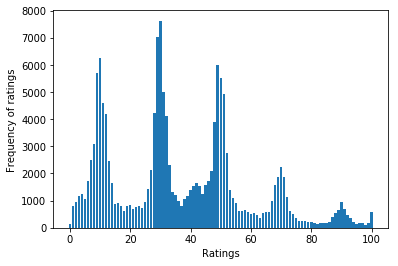

In [8]:
plt.ylabel('Frequency of ratings')
plt.xlabel('Ratings')
plt.bar(x_r, y_r)
plt.show()

From the above graph we can observe that nearly 20% of the total users have given their ratings in the range of 30 to 50. The number of users who rated extremely low (0 - 5) or high (95 - 100) are very few when compared to the overall destribution of the ratings.

**2.User based rating distribution**

Splitting the data into groups based on the 'User' criteria using dataframe.groupby() function. There are 47856 unique users, this results in 47856 groups corresponding to each user and number of ratings give by the user.


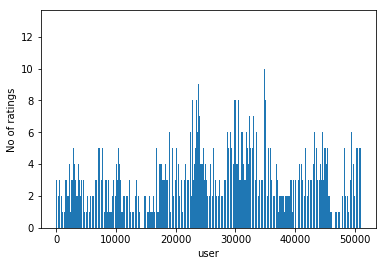

In [9]:
user_data = dataframe.groupby('User')['Rating'].count()
x_u = user_data.index
y_u = user_data.values
plt.xlabel('user')
plt.ylabel('No of ratings')
plt.bar(x_u, y_u)
plt.show()

In [10]:
print('Users who rated the most no. of tracks:\n',user_data.sort_values(ascending=False)[:10])
print('Users who rated the least no. of tracks :\n',user_data.sort_values(ascending=False)[47846:])

Users who rated the most no. of tracks:
 User
32882    13
32204    13
32898    13
32709    13
32463    13
33069    13
32862    12
32586    12
32404    12
33169    12
Name: Rating, dtype: int64
Users who rated the least no. of tracks :
 User
9907     1
9937     1
28979    1
9926     1
29036    1
29043    1
9919     1
9916     1
9908     1
0        1
Name: Rating, dtype: int64


From this destribution we can conclude that the most active user has rated 13 tracks. Each user has rated atleast one track.

**3. Item(track) based ratings distribution**

Grouping based on the tracks. There are 184 uniques tracks, resulting in 184 groups and the number of ratings received by each track.

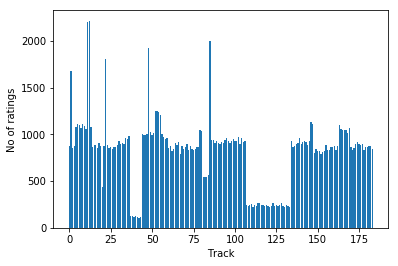

In [11]:
track_data = dataframe.groupby('Track')['Rating'].count()
x_t = track_data.index
y_t = track_data.values
plt.xlabel('Track')
plt.ylabel('No of ratings')
plt.bar(x_t, y_t)
plt.show()

In [12]:
print('Tracks receiving most number of ratings:\n',track_data.sort_values(ascending=False)[:10])
print('Tracks receiving least number of ratings:\n',track_data.sort_values(ascending=False)[180:])

Tracks receiving most number of ratings:
 Track
12    2218
11    2201
85    2001
48    1930
22    1803
1     1678
52    1246
53    1246
54    1237
55    1209
Name: Rating, dtype: int64
Tracks receiving least number of ratings:
 Track
41    118
39    116
43    112
42    106
Name: Rating, dtype: int64


According to this analysis, track with most ratings is track-12 with 2218 ratings.
Track with lease rating is track-42 with 106 ratings.

**Surprise Library for Rating Prediction**

Variuos Surprise library models BaselineOnly, KNNBaseline, KNNBasic, KNNWithMeans, NMF, SVD and SVDpp were implemented and tested for the train data. Upon evaluating based on the RMSE, SVD yielded better results.

Parameter tuning for SVD model was made using GridSearchCV, the best parameter set obtained was (n_factors=100, reg_all= 0.001, lr_all=0.004, n_epochs=100)

The model was further evaluated using various cross-validation iterators like KFold, RepeatedKFold and ShuffleSplit. Model predicted better when evaluated using RepeatedKFold.This is because RepeatedKFold croos validator repeats K-Fold 'n' times with different randomization in each repetition.
 

In [13]:
#SVD Matrix Factorization
algo = SVD(n_factors=150, reg_all= 0.001, lr_all=0.002, n_epochs=120) 
# set of optimized parameters

kf = RepeatedKFold(n_splits = 20)

for trainset, testset in kf.split(data):
    # train and test
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions, verbose=True)

RMSE: 16.2030
RMSE: 16.2503
RMSE: 16.4686
RMSE: 15.8831
RMSE: 16.1959
RMSE: 16.3207
RMSE: 16.1519
RMSE: 16.4551
RMSE: 16.4280
RMSE: 16.4314
RMSE: 15.9896
RMSE: 16.4479
RMSE: 16.2350
RMSE: 16.1048
RMSE: 16.1832
RMSE: 16.5531
RMSE: 16.3376
RMSE: 16.1083
RMSE: 16.2583
RMSE: 16.1600
RMSE: 16.3801
RMSE: 16.1877
RMSE: 15.8837
RMSE: 16.3580
RMSE: 16.4406
RMSE: 16.2063
RMSE: 16.3363
RMSE: 16.3820
RMSE: 16.4017
RMSE: 16.0787
RMSE: 16.5394
RMSE: 16.2108
RMSE: 15.9880
RMSE: 16.2167
RMSE: 16.4130
RMSE: 16.1058
RMSE: 16.3667
RMSE: 16.0522
RMSE: 16.3950
RMSE: 16.4080
RMSE: 15.9875
RMSE: 16.2035
RMSE: 16.3805
RMSE: 16.2572
RMSE: 16.2221
RMSE: 16.3071
RMSE: 16.4555
RMSE: 16.6382
RMSE: 16.0675
RMSE: 16.1618
RMSE: 16.4056
RMSE: 16.0847
RMSE: 16.0393
RMSE: 16.3112
RMSE: 16.0677
RMSE: 16.1956
RMSE: 16.3434
RMSE: 16.1231
RMSE: 16.3741
RMSE: 16.1238
RMSE: 16.3452
RMSE: 16.3337
RMSE: 16.3154
RMSE: 16.4157
RMSE: 16.0989
RMSE: 16.3205
RMSE: 16.1959
RMSE: 16.0784
RMSE: 15.9820
RMSE: 16.0266
RMSE: 16.2781
RMSE: 

Training the model built with the whole train data

In [14]:
# Training with the whole train data

algo.fit(data.build_full_trainset())

Raeding .csv file into the dataframe

In [15]:
test = pd.read_csv('../input/cmpe256-S20-song-recommendation-system/test.csv')
test.head()

,User,Track
0,466,0
1,1173,0
2,566,1
3,49,3
4,772,3


**Creating a dataframe in the required format**
Using the list test_id to store the concatenated result of 'User'-'Track' and test_result to store the respective predicted ratings. These two lists are further used to create a dataframe of shape [31145 rows x 2 columns].

In [16]:
test_result = []
test_id = []
for each, record in test.iterrows():
    #concatenating user-track
    test_id.append(str((record['User']))+'-'+str((record['Track'])))
    test_result.append(algo.predict(record['User'], record['Track']).est)

In [17]:
#converting list to dataframe
final_result=pd.DataFrame({'Id':pd.Series(test_id),'Rating':pd.Series(test_result) })
print(final_result)



              Id     Rating
0          466-0  50.283787
1         1173-0  41.756641
2          566-1  39.700611
3           49-3  31.646270
4          772-3  27.076726
...          ...        ...
31140  46567-170  12.124541
31141  46298-171  26.229316
31142  47876-172  41.812482
31143  48004-172  30.670676
31144  50143-182  45.568120

[31145 rows x 2 columns]


In [18]:
#Coverting pandas dataframe to csv
final_result.to_csv('predictions_repeated.csv',index=False)

**References**

https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html
https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.plot.html
https://www.geeksforgeeks.org/create-a-pandas-dataframe-from-lists/
https://www.geeksforgeeks.org/python-pandas-dataframe-groupby/
https://surprise.readthedocs.io/en/stable/model_selection.html